In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

#DATA PREP
df = pd.read_csv('./data/boston_airbnb/listings.csv')

#remove columns with more than 50% missing values
missing_cols = set(df.columns[df.isnull().mean()>0.5])
df = df.drop(missing_cols, axis=1, inplace=False)

#replace "$" sign in price column, convert to numeric
df['price'] = df['price'].replace({'\$':''}, regex = True)
df['price'] = pd.to_numeric(df['price'] ,errors='coerce')

#drop rows with null prices
df.dropna(subset=['price'], axis=0)

#drop rows with prices more than $400
df = df[df['price']<=400]

print(df.shape)
print(df.columns)

(3459, 86)
Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'transit', 'access', 'interaction', 'house_rules', 'thumbnail_url',
       'medium_url', 'picture_url', 'xl_picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed', 'city', 'state', 'zipcode',
       'market', 'smart_location', 'country_code', 'country', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
    

In [23]:
# df_1 = df[['host_response_rate', 'host_acceptance_rate', 
#         'latitude', 'longitude', 'property_type', 'room_type',
#        'accommodates', 'bathrooms', 'bedrooms', 'beds',
#         'price', 'guests_included', 
#        'minimum_nights', 'maximum_nights', 'availability_30', 'availability_60', 'availability_90',
#        'availability_365', 'number_of_reviews', 'bed_type',
#        'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
#        'review_scores_checkin', 'review_scores_communication',
#        'review_scores_location', 'reviews_per_month']]

df_1 = df[['accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'guests_included', 'number_of_reviews', 'bed_type' ]]

print(df_1.head())
print(df_1.shape)

   accommodates  bathrooms  bedrooms  beds  price  guests_included  \
0             4        1.5       2.0   3.0  250.0                1   
1             2        1.0       1.0   1.0   65.0                0   
2             2        1.0       1.0   1.0   65.0                1   
3             4        1.0       1.0   2.0   75.0                2   
4             2        1.5       1.0   2.0   79.0                1   

   number_of_reviews  bed_type  
0                  0  Real Bed  
1                 36  Real Bed  
2                 41  Real Bed  
3                  1  Real Bed  
4                 29  Real Bed  
(3459, 8)


In [24]:
cat_df = df_1.select_dtypes(include=['object'])
cat_cols_lst = cat_df.columns
print(cat_cols_lst)

Index(['bed_type'], dtype='object')


In [25]:
vals = df_1['bed_type'].value_counts()
print(vals)

Real Bed         3328
Futon              51
Airbed             39
Pull-out Sofa      31
Couch              10
Name: bed_type, dtype: int64


In [26]:
def create_dummy_df(df, cat_cols, dummy_na):
    for col in  cat_cols:
        try:
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

In [27]:
df_2 = create_dummy_df(df_1, cat_cols_lst, False)
print(df_2)

      accommodates  bathrooms  bedrooms  beds  price  guests_included  \
0                4        1.5       2.0   3.0  250.0                1   
1                2        1.0       1.0   1.0   65.0                0   
2                2        1.0       1.0   1.0   65.0                1   
3                4        1.0       1.0   2.0   75.0                2   
4                2        1.5       1.0   2.0   79.0                1   
...            ...        ...       ...   ...    ...              ...   
3580             3        1.0       1.0   1.0   69.0                1   
3581             2        1.0       1.0   1.0  150.0                1   
3582             4        1.0       1.0   1.0  198.0                1   
3583             2        1.0       1.0   1.0   65.0                1   
3584             2        1.0       1.0   1.0   65.0                1   

      number_of_reviews  bed_type_Couch  bed_type_Futon  \
0                     0               0               0   
1    

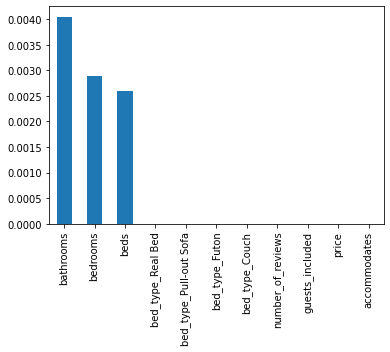

In [31]:
vals = df_2.isnull().mean().sort_values(ascending=False)
(vals).plot(kind="bar");

In [33]:
df_3 = df_2.dropna()
df_3.shape


(3431, 11)

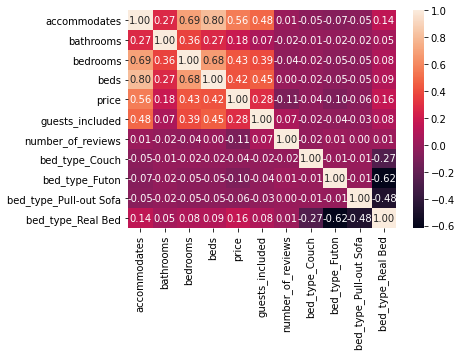

In [34]:
sns.heatmap(df_3.corr(), annot=True, fmt=".2f");

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


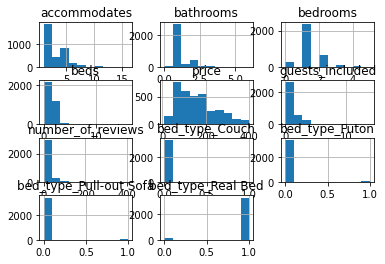

In [35]:
df_3.hist();


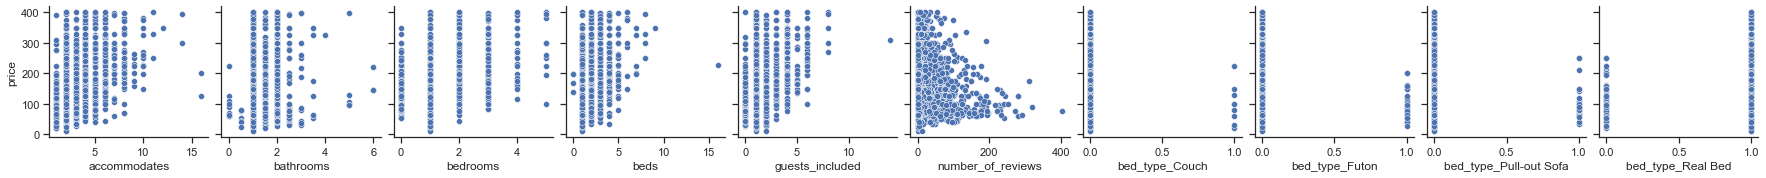

In [41]:
sns.set_theme(style="ticks")
sns.pairplot(data=df_3, y_vars='price', x_vars=['accommodates', 'bathrooms', 'bedrooms', 'beds',
       'guests_included', 'number_of_reviews', 'bed_type_Couch',
       'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed'] )

In [51]:
def fit_linear_mod(df, response_col, explanatory_cols, test_size=.3, rand_state=42):

    y = df[response_col]
    X = df[explanatory_cols]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
   
    lm_model = LinearRegression(normalize=True) 
    lm_model.fit(X_train, y_train)

    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)

    test_score = r2_score(y_test, y_test_preds)
    train_score = r2_score(y_train, y_train_preds)

    return test_score, train_score, lm_model, X_train, X_test, y_train, y_test

In [57]:
response_col = 'price'
explanatory_cols = ['accommodates', 'bathrooms', 'bedrooms', 'beds', 'guests_included', 'number_of_reviews',
                    'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed']

test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(df_3, response_col, explanatory_cols)

print(test_score)
print(train_score)

0.34894571327975543
0.3343000232312592


In [58]:
response_col = 'price'
explanatory_cols = ['accommodates', 'bedrooms', 'beds', 'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa', 'bed_type_Real Bed' ]

test_score, train_score, lm_model, X_train, X_test, y_train, y_test = fit_linear_mod(df_3, response_col, explanatory_cols)

print(test_score)
print(train_score)

0.3383130533139722
0.3204411090059668


In [60]:
def coef_weights(coefficients, X_train):
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

In [62]:
coef_df = coef_weights(lm_model.coef_, X_train)
print(coef_df)

                  est_int      coefs  abs_coefs
6       bed_type_Real Bed  58.038807  58.038807
3          bed_type_Couch  51.378710  51.378710
0            accommodates  28.028804  28.028804
5  bed_type_Pull-out Sofa  25.262807  25.262807
4          bed_type_Futon  12.528517  12.528517
1                bedrooms  11.977396  11.977396
2                    beds  -7.367036   7.367036
